In [1]:
import os
import glob
import cv2
import time
import copy
import pickle  # Log dictionary data
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sn

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F # stateless functions
import torchvision.transforms as T
import torchvision.models as models

import multiprocessing
# We must import this explicitly, it is not imported by the top-level
# multiprocessing module.
import multiprocessing.pool

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score,confusion_matrix
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from datetime import datetime
from multiprocessing import Manager
from PIL import Image

In [2]:
class CFG:
    batch_size = 16
    debug = False
    device = torch.device('cuda')
    dtype = torch.float32
    epochs = 12
    lr = 1e-4
    model_name = 'resnet'
    num_classes = 6
    nworkers = 3
    nfolds = 4
    seed = 524
    TRAIN = '../yi_data/panda-16x128x128-tiles-data/train/'
    LABELS = '../data/train.csv'

# Split Data

In [3]:
train = pd.read_csv(CFG.LABELS).set_index('image_id')
files = sorted(set([p[:32] for p in os.listdir(CFG.TRAIN)]))
train = train.loc[files].reset_index()

if CFG.debug:
    df = train.sample(n=50, random_state=CFG.seed).copy()
else:
    df = train.copy()

# Generate train/validation sets containing the same distribution of isup_grade
splits = StratifiedKFold(n_splits=CFG.nfolds, random_state=CFG.seed, shuffle=True)
splits = list(splits.split(df,df.isup_grade))
# Assign split index to training samples
folds_splits = np.zeros(len(df)).astype(np.int)
for i in range(CFG.nfolds):
    folds_splits[splits[i][1]] = i
df['split'] = folds_splits
df.head()

,image_id,data_provider,isup_grade,gleason_score,split
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,2
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,3
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,1
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,1
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,0


In [4]:
# https://www.kaggle.com/yasufuminakama/panda-se-resnext50-regression-baseline
class TrainDataset(Dataset):
    """Prostate Cancer Biopsy Dataset"""
    
    def __init__(self, df, labels, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file
            root_dir (string): Path to the directory with all images
            transform (callable, optional): Optional transform to be applied on an image sample
        """
        # Shuffle dataframes with fixed seed; otherwise, validation set only get cancerous samples
        self.df = df
        self.labels = labels
        self.transform = transform
        # For weighted sampler
        class_counts = [len(labels[labels==g]) for g in range(CFG.num_classes)]
        self.num_samples = sum(class_counts)
        class_weights = [self.num_samples/class_counts[i] for i in range(len(class_counts))]
        self.weights = [class_weights[labels[i]] for i in range(self.num_samples)]
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        #worker = torch.utils.data.get_worker_info()
        #worker_id = worker.id if worker is not None else -1
        #start = time.time()
        # https://stackoverflow.com/questions/33369832/read-multiple-images-on-a-folder-in-opencv-python
        img_fns = [fn for fn in glob.glob(f"{CFG.TRAIN}/{self.df['image_id'][idx]}_*.png")]
        imgs = [cv2.imread(fn) for fn in img_fns]
        # (D,W,H)
        img = cv2.hconcat([cv2.vconcat([imgs[0], imgs[1], imgs[2], imgs[3]]),
                           cv2.vconcat([imgs[4], imgs[5], imgs[6], imgs[7]]),
                           cv2.vconcat([imgs[8], imgs[9], imgs[10], imgs[11]]),
                           cv2.vconcat([imgs[12], imgs[13], imgs[14], imgs[15]])])
        img = Image.fromarray(img)
        
        if self.transform:
            img = self.transform(img)
            
        label = self.labels[idx]
        #end = time.time()
        return img, label

## Transforms

In [5]:
def get_transforms(phase):
    assert phase in {'train', 'val'}
    
    if phase == 'train':
        return T.Compose([
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip(),
            T.RandomRotation(15, fill=255),
            T.ToTensor(),
            T.Normalize(
                mean=[0.8776, 0.8186, 0.9090],
                std=[0.1659, 0.2507, 0.1357],
            ),
        ])
    else:
        return T.Compose([
            T.ToTensor(),
            T.Normalize(
                mean=[0.8776, 0.8186, 0.9090],
                std=[0.1659, 0.2507, 0.1357],
            ),
        ])

In [6]:
# Use fold idx as validation set
def data_loader(fold_idx):
    train_idx = df[df['split'] != fold_idx].index
    val_idx = df[df['split'] == fold_idx].index

    train_dataset = TrainDataset(df.loc[train_idx].reset_index(drop=True),
                                 df.loc[train_idx].reset_index(drop=True)['isup_grade'],
                                 transform = get_transforms(phase='train'))
    val_dataset = TrainDataset(df.loc[val_idx].reset_index(drop=True),
                               df.loc[val_idx].reset_index(drop=True)['isup_grade'],
                               transform = get_transforms(phase='val'))
    
    train_sampler = WeightedRandomSampler(weights=train_dataset.weights, num_samples=train_dataset.num_samples)
    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, sampler=train_sampler, num_workers=CFG.nworkers)
    val_loader = DataLoader(val_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.nworkers)
    return train_loader, val_loader

In [7]:
def train_model(model, fold, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    # Send the model to GPU/CPU
    model = model.to(device=CFG.device)
    
    train_acc_history = []
    val_acc_history = []
    loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()   # Set model to training phase
            else:
                model.eval()    # Set model to evaluate phase
            
            avg_loss = 0.0
            running_corrects = 0
            
            print(' ', end='', flush=True)  # To workaround tqdm issue in multiprocess
            for inputs, labels in tqdm(dataloaders[phase],
                                       desc='[{}] {}/{}({:5s})'.format(fold, epoch+1,num_epochs,phase)):
                inputs = inputs.to(device=CFG.device, dtype=CFG.dtype)
                labels = labels.to(device=CFG.device, dtype=torch.long)
                #print(labels)
                
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward, track history if only in training
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    pred = torch.argmax(outputs, 1)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # Statistics
                avg_loss += loss.item()*(inputs.size(0)/len(dataloaders[phase].dataset))  # len(dataloaders[phase].dataset) not len(dataloaders[phase])
                running_corrects += torch.sum(pred == labels)
            
            # End of epoch
            with torch.no_grad():
                epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

                if phase == 'val':
                    val_acc_history.append(epoch_acc)
                    # deep copy the model
                    if epoch_acc > best_acc:
                        best_acc = epoch_acc
                        best_model_wts = copy.deepcopy(model.state_dict())
                    # Apply lr_scheduler
                    if scheduler is not None:
                        scheduler.step(avg_loss)
                else:
                    train_acc_history.append(epoch_acc)
                    loss_history.append(avg_loss)
                print('[{}] {} Loss: {:4f} Acc: {:4f}'.format(fold, phase, avg_loss, epoch_acc))
    
    time_elapsed = time.time() - since
    print('[{}] Training complete in {:.0f}m {:0f}s'.format(fold, time_elapsed//60, time_elapsed%60))
    print('[{}] Best val Acc: {:4f}'.format(fold, best_acc))
    print()
    
    model.load_state_dict(best_model_wts)
                      
    return model, loss_history, train_acc_history, val_acc_history

In [8]:
"""Multiprocessing
"""
class NoDaemonProcess(multiprocessing.Process):
    # make 'daemon' attribute always return False
    def _get_daemon(self):
        return False
    def _set_daemon(self, value):
        pass
    daemon = property(_get_daemon, _set_daemon)

# We sub-class multiprocessing.pool.Pool instead of multiprocessing.Pool
# because the latter is only a wrapper function, not a proper class.
class MyPool(multiprocessing.pool.Pool):
    Process = NoDaemonProcess

def train_fn(fold):
    model_ft = initialize_model(CFG.model_name, CFG.num_classes, use_pretrained=True)
    """
    optimizer = optim.SGD(model_ft.parameters(),
                          lr=CFG.lr,
                          momentum=.9,
                          nesterov=True)
    """
    optimizer = optim.Adam(model_ft.parameters(),
                           lr=CFG.lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True, eps=1e-06)
    #print(f'### FOLD: {fold} ###', flush=True)
    loader_train, loader_val = data_loader(fold)
    best_model, loss_history, train_acc_history, val_acc_history = train_model(model_ft, fold, {'train': loader_train, 'val': loader_val}, F.cross_entropy, optimizer, scheduler, CFG.epochs)

    return best_model, loss_history, train_acc_history, val_acc_history

def progressor(fold):
    best_model, loss_history, train_acc_history, val_acc_history = train_fn(fold)
    return {f'best_mode_{fold}': best_model,
            f'loss_history_{fold}': loss_history,
            f'train_acc_history_{fold}': train_acc_history,
            f'val_acc_history_{fold}': val_acc_history}

## Resnet18
log: resnet_06_01_2020_13_11.pkl

In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            

def initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False):
    """
    Params:
        feature_extract
            True - fine tunning
            False - fix the model
    """
    model_ft = None
    
    if model_name == 'alexnet':
        """AlexNet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs, num_classes)
    elif model_name == 'resnet':
        """Resnet
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
    
    return model_ft

In [10]:
log_dict = {'batch_size': CFG.batch_size,
            'epochs': CFG.epochs,
            'learning_rate': CFG.lr,
            'model': CFG.model_name,
            'nworkers': CFG.nworkers,
            'nfolds': CFG.nfolds,
            'random_seed': CFG.seed}

nfold = range(CFG.nfolds)
result_list = list(MyPool(CFG.nfolds).map(progressor, nfold))

# Accumulate result from each process
for result in result_list:
    log_dict.update(result)

# Log results
log_file = f'{CFG.model_name}_{datetime.now().strftime("%m_%d_%Y_%H_%M")}.pkl'
with open(log_file, 'wb') as pkl_file:
    pickle.dump(log_dict, pkl_file)


[1] train Loss: 1.422420 Acc: 0.410295
 
[2] train Loss: 1.415877 Acc: 0.415240
 


[3] train Loss: 1.408417 Acc: 0.425891
 


[0] train Loss: 1.419086 Acc: 0.420946
 


[2] val Loss: 1.488341 Acc: 0.449601
 


[3] val Loss: 1.477525 Acc: 0.449601
 


[1] val Loss: 1.210173 Acc: 0.508939
 


[0] val Loss: 1.343286 Acc: 0.466717
 


[0] train Loss: 1.281735 Acc: 0.483707
 


[2] train Loss: 1.282899 Acc: 0.478002
 


[1] train Loss: 1.294017 Acc: 0.470268
 


[3] train Loss: 1.281727 Acc: 0.484595
 


[0] val Loss: 1.182551 Acc: 0.537086
 


[3] val Loss: 1.244525 Acc: 0.521491
 


[2] val Loss: 1.269397 Acc: 0.496386
 


[1] val Loss: 1.210364 Acc: 0.524914
 


[0] train Loss: 1.230821 Acc: 0.499303
 


[2] train Loss: 1.214329 Acc: 0.515912
 


[3] train Loss: 1.227653 Acc: 0.500951
 


[1] train Loss: 1.229359 Acc: 0.494865
 


[0] val Loss: 1.158309 Acc: 0.552682
 


[2] val Loss: 1.278480 Acc: 0.505515
 


[3] val Loss: 1.435683 Acc: 0.442754
 


[1] val Loss: 1.247509 Acc: 0.494865
 


[0] train Loss: 1.167185 Acc: 0.531634
 


[2] train Loss: 1.175160 Acc: 0.532015
 


[3] train Loss: 1.156571 Acc: 0.537974
 


[1] train Loss: 1.144424 Acc: 0.543553
 


[0] val Loss: 1.257771 Acc: 0.532141
 


[2] val Loss: 1.192449 Acc: 0.544694
 


[1] val Loss: 1.200117 Acc: 0.542792
 


[3] val Loss: 1.293608 Acc: 0.497147
 


[0] train Loss: 1.136985 Acc: 0.549765
 


[2] train Loss: 1.132710 Acc: 0.547864
 


[3] train Loss: 1.099777 Acc: 0.564854
 


[1] train Loss: 1.139975 Acc: 0.549512
 


[0] val Loss: 1.111747 Acc: 0.566375
 


[2] val Loss: 1.166785 Acc: 0.566375
 


[3] val Loss: 1.160441 Acc: 0.539749
 


[1] val Loss: 1.150223 Acc: 0.553823
 


[0] train Loss: 1.108372 Acc: 0.563839
 


[2] train Loss: 1.067316 Acc: 0.577406
 


[3] train Loss: 1.065017 Acc: 0.577533
 


[1] train Loss: 1.086762 Acc: 0.572968
 


[0] val Loss: 1.226879 Acc: 0.519970
 


[2] val Loss: 1.327778 Acc: 0.510460
 


[3] val Loss: 1.412053 Acc: 0.494865
 


[1] val Loss: 1.126752 Acc: 0.571700
 


[0] train Loss: 1.046593 Acc: 0.587676
 


[3] train Loss: 1.027899 Acc: 0.605046
 


[2] train Loss: 1.013154 Acc: 0.604412
 


[1] train Loss: 1.022760 Acc: 0.602510
 


[0] val Loss: 1.190215 Acc: 0.562191
 


[3] val Loss: 1.253966 Acc: 0.534043
 


[2] val Loss: 1.263350 Acc: 0.522632
 


[1] val Loss: 1.166936 Acc: 0.562952
 


[0] train Loss: 1.001245 Acc: 0.615316
 


[1] train Loss: 1.010713 Acc: 0.606568
 


[3] train Loss: 0.971918 Acc: 0.619881
 


[2] train Loss: 0.995353 Acc: 0.611386
 


Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
[0] val Loss: 1.142764 Acc: 0.571320
 


[1] val Loss: 1.206878 Acc: 0.529859
 


Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
[3] val Loss: 1.173982 Acc: 0.561811
 


Epoch     8: reducing learning rate of group 0 to 1.0000e-05.
[2] val Loss: 1.284170 Acc: 0.516546
 


[0] train Loss: 0.902857 Acc: 0.659059
 


[3] train Loss: 0.860877 Acc: 0.671992
 


[1] train Loss: 0.961052 Acc: 0.627995
 


[2] train Loss: 0.880092 Acc: 0.671231
 


[0] val Loss: 1.059639 Acc: 0.593762
 


[3] val Loss: 1.066290 Acc: 0.594142
 


Epoch     9: reducing learning rate of group 0 to 1.0000e-05.
[1] val Loss: 1.154008 Acc: 0.566375
 


[2] val Loss: 1.056588 Acc: 0.595664
 


[0] train Loss: 0.833698 Acc: 0.683783
 


[2] train Loss: 0.836747 Acc: 0.686953
 


[3] train Loss: 0.801335 Acc: 0.698745
 


[1] train Loss: 0.835354 Acc: 0.689869
 


[0] val Loss: 1.042653 Acc: 0.605553
 


[3] val Loss: 1.072366 Acc: 0.597185
 


[2] val Loss: 1.077063 Acc: 0.586154
 


[1] val Loss: 1.039203 Acc: 0.608216
 


[0] train Loss: 0.796686 Acc: 0.702041
 


[3] train Loss: 0.761107 Acc: 0.723089
 


[2] train Loss: 0.794155 Acc: 0.711931
 


[1] train Loss: 0.768494 Acc: 0.713453
 


[3] val Loss: 1.097344 Acc: 0.583111
 


[0] val Loss: 1.051881 Acc: 0.599467
 


[2] val Loss: 1.095938 Acc: 0.583492
 


[1] val Loss: 1.041422 Acc: 0.604793
 


[0] train Loss: 0.776373 Acc: 0.712185
 


[2] train Loss: 0.751610 Acc: 0.728541
 


[3] train Loss: 0.750293 Acc: 0.721948
 


[1] train Loss: 0.745948 Acc: 0.721567
 


[0] val Loss: 1.070396 Acc: 0.594903
[0] Training complete in 547m 15.503763s
[0] Best val Acc: 0.605553


Epoch    12: reducing learning rate of group 0 to 1.0000e-06.
[2] val Loss: 1.071180 Acc: 0.597566
[2] Training complete in 547m 19.210738s
[2] Best val Acc: 0.597566


Epoch    12: reducing learning rate of group 0 to 1.0000e-06.
[3] val Loss: 1.072218 Acc: 0.589958
[3] Training complete in 547m 20.099689s
[3] Best val Acc: 0.597185


[1] val Loss: 1.044080 Acc: 0.607455
[1] Training complete in 547m 25.458825s
[1] Best val Acc: 0.608216



In [11]:
"""
for fold in range(CFG.nfolds):
    best_model, loss_history, train_acc_history, val_acc_history = train_fn(fold)
    log_dict[f'best_mode_{fold}'] = best_model
    log_dict[f'loss_history_{fold}'] = loss_history
    log_dict[f'train_acc_history_{fold}'] = train_acc_history
    log_dict[f'val_acc_history_{fold}'] = val_acc_history
"""

"\nfor fold in range(CFG.nfolds):\n    best_model, loss_history, train_acc_history, val_acc_history = train_fn(fold)\n    log_dict[f'best_mode_{fold}'] = best_model\n    log_dict[f'loss_history_{fold}'] = loss_history\n    log_dict[f'train_acc_history_{fold}'] = train_acc_history\n    log_dict[f'val_acc_history_{fold}'] = val_acc_history\n"

"""
Graphs
1. loss vs. iterations
2. Train/Validation accuracy along epoch
"""
plt.subplot(2,1,1)
plt.plot(log_dict['loss_history_0'], 'o')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(log_dict['train_acc_history_0'], '-o')
plt.plot(log_dict['val_acc_history_0'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.tight_layout(pad=3)
plt.show()

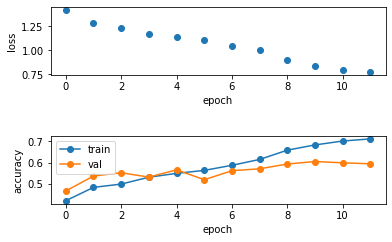

In [12]:
# read python dict back from the file
#with open(log_file, 'rb') as pfile:
#    test_dict = pickle.load(pfile)
"""
Graphs
1. loss vs. iterations
2. Train/Validation accuracy along epoch
"""
plt.subplot(2,1,1)
plt.plot(log_dict['loss_history_0'], 'o')
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(2,1,2)
plt.plot(log_dict['train_acc_history_0'], '-o')
plt.plot(log_dict['val_acc_history_0'], '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.tight_layout(pad=3)
plt.show()

In [13]:
preds, targets = [], []
for fold in range(CFG.nfolds):
    model_fd = log_dict[f'best_mode_{fold}']
    _, loader_val = data_loader(fold)
    for inputs, labels in tqdm(loader_val):
        inputs = inputs.to(device=CFG.device, dtype=CFG.dtype)
        labels = labels.to(device=CFG.device, dtype=torch.long)
                
        # Forward, track history if only in training
        with torch.no_grad():
            outputs = model_fd(inputs)
            pred = torch.argmax(outputs, 1)
        preds.append(pred)
        targets.append(labels)

Kappa: 0.7485453974993297


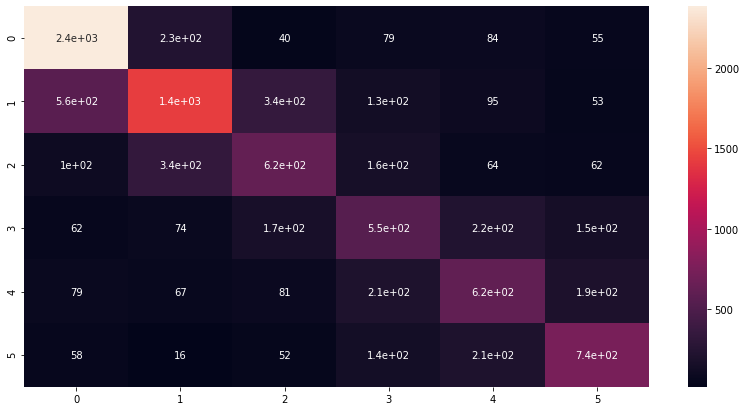

In [14]:
p = torch.cat(preds).cpu()
t = torch.cat(targets).cpu()
kappa = cohen_kappa_score(t, p, weights='quadratic')
print(f'Kappa: {kappa}')
conf_mat = confusion_matrix(t,p)
#plt.matshow()
plt.figure(figsize=(14,7))
sn.heatmap(conf_mat, annot=True)